# FInal Project 3.2_Leaf Classification

## Import Statements

In [36]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import glob
import skimage.morphology as skmorph
import skimage.feature as skfeature
from sklearn.metrics import confusion_matrix

## Input Image

In [37]:
input_path = glob.glob("project/Leaf_Classification_2/*.jpg")
input_img = [cv.imread(img) for img in input_path]
num = 1

## Functions

In [38]:
# Euclidean Distance 
def euclidean(input_img,center):
    y,x,z = input_img.shape
    
    # Flattern
    positions = input_img.reshape(y*x,z)
    centers = center*np.ones((y*x,1))
    
    # Find Euclidean Distances
    distances = np.sqrt(np.sum((positions-centers)**2, axis = 1))
    
    distances = distances.reshape((y,x))
    
    return distances

In [39]:
# Opening Function
def opening(segment_img):
    se = skmorph.disk(3)
    morph_img = cv.morphologyEx(segment_img, cv.MORPH_OPEN, se)
    
    return morph_img

In [40]:
# Connected Component Function
def connectedComponent(morph_img):
    _, labels_img = cv.connectedComponents(morph_img)

    groups, counts = np.unique(labels_img, return_counts = True)

    target_size = (morph_img.shape[0] * morph_img.shape[1]) * 0.03
    target_groups = np.argwhere(counts > target_size)[1:]
    num_groups = target_groups.shape[0]
    #print("Target Groups =",num_groups)
    
    connect_img = np.isin(labels_img, target_groups)
    connect_img = connect_img.astype(np.uint8)
    
    return connect_img,num_groups

In [41]:
# Fill Hole Function
def fillHole(connect_img):
    fill_img = connect_img.copy()
    mask = np.zeros((fill_img.shape[0]+2, fill_img.shape[1]+2), np.uint8)

    cv.floodFill(fill_img, mask, (0, 0), 255)
    fill_img = 255 - fill_img
    flood_img = connect_img | fill_img
    
    return flood_img

In [42]:
# Corner Detection Function
def cornerDetection(flood_img):
    k_size = 7
    g_filter = cv.getGaussianKernel(k_size,-1)
    g_filter = g_filter*g_filter.T

    blur_img = cv.filter2D(flood_img,-1,g_filter)
    #####################################################################  
    harris_result = skfeature.corner_harris(blur_img, k=0.05) # output is corner response value

    corner_pos = skfeature.corner_peaks(harris_result,
                                        min_distance=30,
                                        threshold_rel=0.05)
    num_cornerPosition = corner_pos.shape[0]
    
    subpix_pos = skfeature.corner_subpix(blur_img, corner_pos,
                                        window_size=100, alpha=0.7)
    
    corn_img = cv.cvtColor(blur_img, cv.COLOR_GRAY2RGB)
    
    for y, x in subpix_pos:
        if np.isnan(y) or np.isnan(x):
            continue
        cv.circle(corn_img, (int(x), int(y)), 5, (0,0,255), -1)
    
    return corn_img,num_cornerPosition,blur_img

## Main Porogram

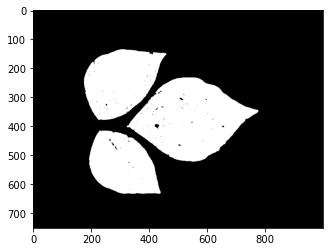

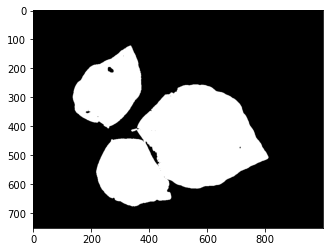

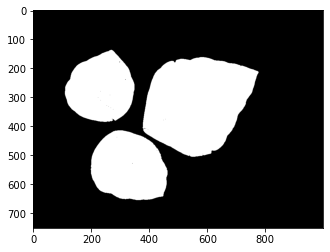

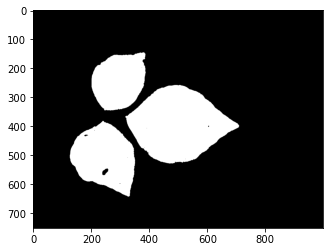

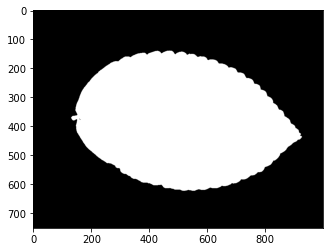

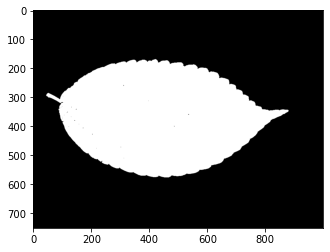

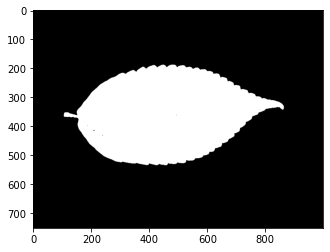

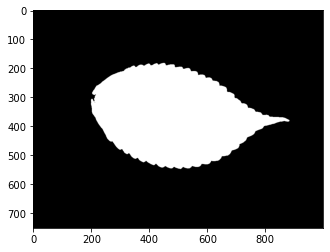

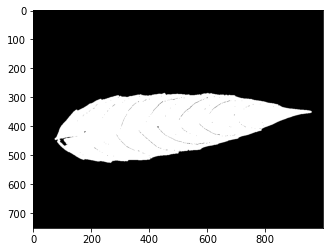

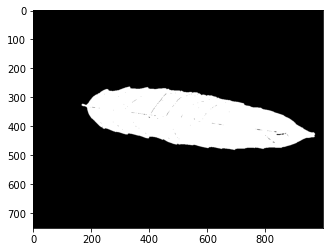

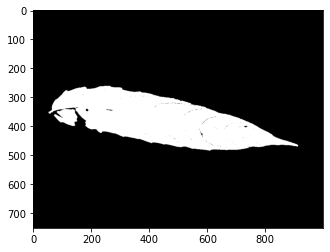

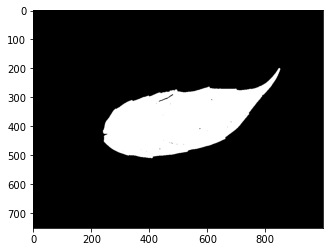

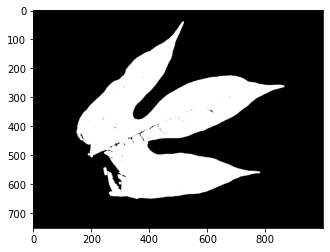

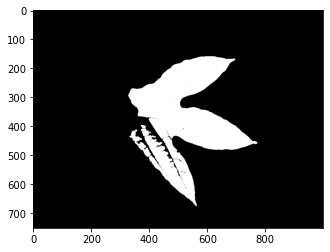

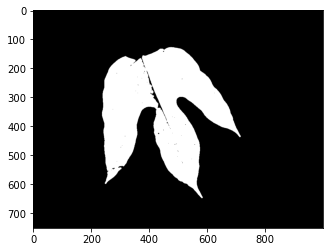

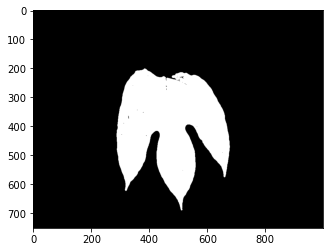

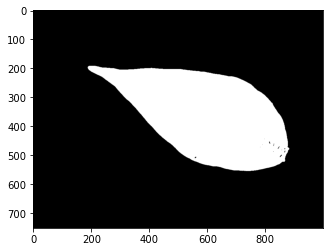

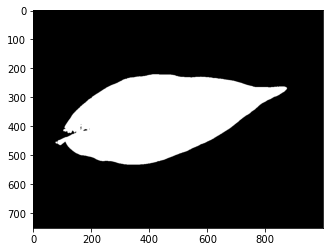

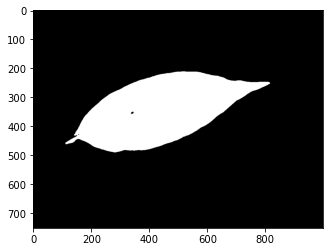

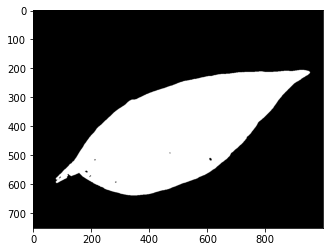

['Class A', 'Class A', 'Class A', 'Class A', 'Class B', 'Class B', 'Class B', 'Class B', 'Class C', 'Class D', 'Class C', 'Class C', 'Class D', 'Class C', 'Class D', 'Class D', 'Class E', 'Class E', 'Class E', 'Class E']


In [43]:
check_list = ["Class A","Class A","Class A","Class A","Class B","Class B","Class B","Class B","Class C","Class C","Class C","Class C","Class D","Class D","Class D","Class D","Class E","Class E","Class E","Class E"]
Class = []

for i in range(len(input_img)):
    image = cv.cvtColor(input_img[i],cv.COLOR_BGR2RGB)
#####################################################################    
    center = (50,190,0)
    segment_img = euclidean(image,center)

    # Cut Off
    segment_img_height, segment_img_width = segment_img.shape

    cutoff = 135
    for i in range(segment_img_height):
        for j in range(segment_img_width):
            if segment_img[i][j] > cutoff:
                segment_img[i][j] = 0
            else:
                segment_img[i][j] = 255
    segment_img = segment_img.astype(np.uint8)
    cv.imwrite("project/segment/"+str(num)+str(center)+str(cutoff)+".jpg",segment_img)
#####################################################################  
    morph_img = opening(segment_img)
    cv.imwrite("project/morphology/"+str(num)+".jpg",morph_img)
#####################################################################  
    connect_img,num_groups = connectedComponent(morph_img)
    cv.imwrite("project/connected_component/"+str(num)+".jpg",connect_img)
#####################################################################  
    flood_img = fillHole(connect_img)
    cv.imwrite("project/flood/"+str(num)+str(center)+str(cutoff)+".jpg",flood_img)
#####################################################################  
    corn_img,num_cornerPosition,blur_img = cornerDetection(flood_img)
    cv.imwrite("project/blur/"+str(num)+".jpg",blur_img)
    cv.imwrite("project/corner/"+str(num)+".jpg",corn_img)
    #print(num,"_",num_cornerPosition)
#####################################################################  


    if num_groups >= 2 and num_groups <=3:
        type = "Class A"
        Class.append(type)

    elif num_groups == 1:
        if  num_cornerPosition > 13:
            type = "Class B"
            Class.append(type)

        elif num_cornerPosition > 11:
            type = "Class C"
            Class.append(type)

        elif num_cornerPosition > 5:
            type = "Class D"
            Class.append(type)

        elif num_cornerPosition > 1:
            type = "Class E"
            Class.append(type)

    else:
        type = "New Class"
        Class.append(type)
    
    
    plt.imshow(connect_img,cmap ='gray')
    plt.show()
    

    
    num = num+1
print(Class) 

## Performance Evaluation

## 1.Confusion Matrix, Recall and Precision

In [44]:
# Confusion Matrix
matrix = confusion_matrix(check_list,Class)
print(matrix)
print("")

# Recall
print("Recall for Class A",matrix[0,0]/sum(matrix[:,0])) # Class A
print("Recall for Class B",matrix[1,1]/sum(matrix[:,1])) # Class B
print("Recall for Class B",matrix[2,2]/sum(matrix[:,2])) # Class C
print("Recall for Class B",matrix[3,3]/sum(matrix[:,3])) # Class D
print("Recall for Class B",matrix[4,4]/sum(matrix[:,4])) # Class E
# print("Recall for New Class",matrix[5,5]/sum(matrix[:,5])) # New CLass
print("")

# Precision
print("Precision for Class A",matrix[0,0]/sum(matrix[0,:])) # Class A
print("Precision for Class B",matrix[1,1]/sum(matrix[1,:])) # Class B
print("Precision for Class B",matrix[2,2]/sum(matrix[2,:])) # Class C
print("Precision for Class B",matrix[3,3]/sum(matrix[3,:])) # Class D
print("Precision for Class B",matrix[4,4]/sum(matrix[4,:])) # Class E
# print("Precision for New Class",matrix[5,5]/sum(matrix[5,:])) # New CLass

[[4 0 0 0 0]
 [0 4 0 0 0]
 [0 0 3 1 0]
 [0 0 1 3 0]
 [0 0 0 0 4]]

Recall for Class A 1.0
Recall for Class B 1.0
Recall for Class B 0.75
Recall for Class B 0.75
Recall for Class B 1.0

Precision for Class A 1.0
Precision for Class B 1.0
Precision for Class B 0.75
Precision for Class B 0.75
Precision for Class B 1.0


## 2.Accuracy and Error

In [45]:
# Accuracy
accuracy = (matrix[0,0]+matrix[1,1]+matrix[2,2]+matrix[3,3]+matrix[4,4])/matrix.sum()
print("Accuracy = ",accuracy,"")
print("")

# Error
error = 1-accuracy
print("Error = ",error)

Accuracy =  0.9 

Error =  0.09999999999999998
